# Testing

This notebook includes the execution of the testing for trained models.

In [2]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from model.one_model.one_stage_models import ResNet50OneStage, ResNet18OneStage
from model.multi_stage_model.multi_stage_model import TwoStageModel
from data.dataset import CheXpertDataset

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## Test Dataset

In [81]:
params_transform = {
    "resize": (256, 256),
}

transform = transforms.Compose([
    transforms.Resize(params_transform["resize"]),
    transforms.ToTensor(),
])

targets = {
            # "sex": 1,
            # "age": 2,
            # "frontal/lateral": 3,
            # "ap/pa": 4,
            # "no_finding": 5,
            # "enlarged_cardiomediastinum": 6,
            # "cardiomegaly": 7,
            # "lung_opacity": 8,
            # "lung_lesion": 9,
            # "edema": 10,
            # "consolidation": 11,
            # "pneumonia": 12,
            # "atelectasis": 13,
            # "pneumothorax": 14,
            # "pleural_effusion": 15,
            # "pleural_other": 16,
            # "fracture": 17,
            "support_devices": 18,
            # "ap/pa map": 22,
        }

test_dataset = CheXpertDataset(
    csv_file="data/splitted/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)

Test dataset size: 5627
Example
Example
labels: [1.]
torch.Size([1, 256, 256])


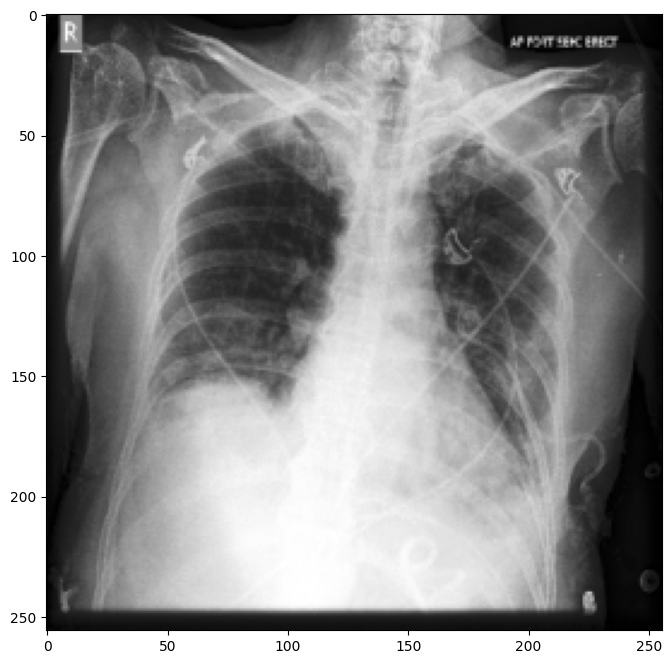

In [82]:
print(f"Test dataset size: {len(test_dataset)}")

print("Example")
print("Example")
img, labels = test_dataset[0]
print(f"labels: {labels}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

# One stage model

Testing of the one stage model.

## Define model

In [83]:
params = {
    "train_transfrom": params_transform,
    "lr": 0.001,
    "save_epoch": 5,
    "batch_size": 128,
    "num_epochs": 100,
    "input_channels": 1,
    "optimizer": "adam",
    "num_workers": 0,
    # BCE with Sigmoid activation function
    "loss_fn": "torch.nn.BCEWithLogitsLoss()",
    # For multilabel: MultiLabelSoftMarginLoss
    "metrics": ["accuracy", "f1_score", "precision", "recall", "confusion_matrix"],
    "confidence_threshold": 0.5,
}

weights = "weights/250111/baseline/model_epoch_90.pth"

model = ResNet50OneStage(params=params, targets=targets, input_channels=params['input_channels'])
model.load_model(weights)

## Testing one stage model

In [84]:
task = "one_stage_test"

dirname = os.getcwd()
path = os.path.join(dirname, "logs", f"{model.name}_{task}")
if not os.path.exists(path):
    os.makedirs(path)
    num_of_runs = 0
else:
    num_of_runs = len(os.listdir(path))
path = os.path.join(
    path, f"run_{num_of_runs:03d}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
)
os.makedirs(path)

# Create tensorboard logger
tb_logger = SummaryWriter(path)

model.test(test_dataset, tb_logger)

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:21<00:00,  2.10it/s, test_loss=0.383797]

Test loss: 0.3837971919477314
Test support_devices accuracy: 0.932823896408081
Test support_devices precision: 0.9554863572120667
Test support_devices recall: 0.9747710824012756
Test support_devices confusion_matrix: tensor([[  33.,  243.],
        [ 135., 5216.]])


# Two stage model

Testing of the two stage model.

## Define model

In [85]:
params = {
    "train_transfrom": params_transform,
    "lr": 0.001,
    "save_epoch": 5,
    "batch_size": 4,
    "num_epochs": 100,
    "input_channels": 1,
    "optimizer": "adam",
    "num_workers": 0,
    # BCE with Sigmoid activation function
    "loss_fn": "torch.nn.BCEWithLogitsLoss()",
    # For multilabel: MultiLabelSoftMarginLoss
    "metrics": ["accuracy", "f1_score", "precision", "recall", "confusion_matrix"],
    "confidence_threshold": 0.7,
    "confidence_threshold_first_ap_pa": 0.5,
}

weights_first_stage = "weights/250110/two_stage_first_epoch25.pth"
weights_second_stage_ap = "weights/250111/ap/model_epoch_45.pth"
weights_second_stage_pa = "weights/250111/pa/model_epoch_50.pth"

model = TwoStageModel(
    params=params, 
    model_ap_pa_classification=weights_first_stage, 
    model_ap=weights_second_stage_ap, 
    model_pa=weights_second_stage_pa,
    targets=targets,
)

## Testing two stage model

In [86]:
dirname = os.getcwd()
path = os.path.join(dirname, "logs", f"{model.name}")
if not os.path.exists(path):
    os.makedirs(path)
    num_of_runs = 0
else:
    num_of_runs = len(os.listdir(path))
path = os.path.join(path, f"test_{num_of_runs:03d}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
os.makedirs(path)

# Create tensorboard logger
tb_logger = SummaryWriter(path)

# Save the model parameters
model.save_hparams(path)

model.test(test_dataset, tb_logger)

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:25<00:00, 55.28it/s, test_loss=0.301609]


Test loss: 0.3016094256061835
Test support_devices accuracy: 0.9260707497596741
Test support_devices precision: 0.9531680345535278
Test support_devices recall: 0.9699121713638306
Test support_devices auroc: 0.6057813926152229
Test support_devices auc: tensor([0.8254], device='cuda:0')
Test support_devices confusion_matrix: tensor([[  12.,  264.],
        [  70., 5281.]])
